In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-04-11 13:56:48.280086: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 13:56:48.370645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744358208.408119   35314 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744358208.419813   35314 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 13:56:48.535309: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Using device: cuda


In [2]:
dataset_path = "datasets/FF++"
REAL_PATH = os.path.join(dataset_path, "real")
FAKE_PATH = os.path.join(dataset_path, "fake")
OUTPUT_FRAME_SIZE = (128, 128)
FRAME_COUNT = 10
MAX_VIDEOS = 200

def extract_frames(video_path, output_size=(128, 128), frame_count=10):
    """Extract a fixed number of frames from a video."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)
    
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)  # uint8 numpy array
    cap.release()
    return frames if len(frames) == frame_count else None

# Collect data
data = []
labels = []

# Real videos
print("Processing real videos...")
for video_file in tqdm(os.listdir(REAL_PATH)[:MAX_VIDEOS]):
    video_path = os.path.join(REAL_PATH, video_file)
    frames = extract_frames(video_path, OUTPUT_FRAME_SIZE, FRAME_COUNT)
    if frames:
        data.append(frames)
        labels.append(0)  # 0 for real

# Fake videos
print("Processing fake videos...")
for video_file in tqdm(os.listdir(FAKE_PATH)[:MAX_VIDEOS]):
    video_path = os.path.join(FAKE_PATH, video_file)
    frames = extract_frames(video_path, OUTPUT_FRAME_SIZE, FRAME_COUNT)
    if frames:
        data.append(frames)
        labels.append(1)  # 1 for fake

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}")

Processing real videos...


100%|██████████| 200/200 [02:07<00:00,  1.57it/s]


Processing fake videos...


100%|██████████| 200/200 [02:04<00:00,  1.60it/s]

Train samples: 280, Val samples: 60, Test samples: 60


In [3]:
# Load processor and model
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

In [4]:
# Enhanced augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.Resize((224, 224)),  # Match ViT’s expected size
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)])

class VideoDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data  # List of video sequences
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence = self.data[idx]  # List of frames
        label = self.labels[idx]
        sequence = [self.transform(frame) for frame in sequence]
        sequence = torch.stack(sequence)  # Shape: (seq_len, 3, 224, 224), e.g., (10, 3, 224, 224)
        return sequence, torch.tensor(label, dtype=torch.long)

# Create datasets and loaders
batch_size = 10
train_dataset = VideoDataset(X_train, y_train, train_transform)
val_dataset = VideoDataset(X_val, y_val, val_transform)
test_dataset = VideoDataset(X_test, y_test, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [5]:
# Load pre-trained ViT with a binary classification head (adjust num_labels as needed)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Use 10 if you have 10 classes
    ignore_mismatched_sizes=True
)

model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [6]:
class VideoClassifier(nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model.vit  # Use the ViT backbone (excludes the original head)
        self.lstm = nn.LSTM(input_size=768, hidden_size=64, batch_first=True)  # 768 is ViT-base’s embedding size
        self.fc = nn.Linear(64, 2)  # Adjust to 10 for 10 classes
    
    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()  # e.g., (batch, 10, 3, 224, 224)
        x = x.view(batch_size * seq_len, C, H, W)  # Flatten batch and sequence
        x = self.vit(x).last_hidden_state[:, 0, :]  # Get [CLS] token embeddings: (batch*seq_len, 768)
        x = x.view(batch_size, seq_len, 768)  # Reshape for LSTM
        x, _ = self.lstm(x)  # Process sequence
        x = self.fc(x[:, -1, :])  # Use last LSTM output for classification
        return x

# Initialize the video model
video_model = VideoClassifier(model).to(device)

In [7]:
optimizer = torch.optim.AdamW(video_model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [8]:
for param in video_model.vit.parameters():
    param.requires_grad = False  # Freeze ViT backbone

In [9]:
num_epochs = 100

# Write the training loop with tqdm for visualizing progress and it will contain train and validation steps with accuracy and both losses
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    video_model.train()
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = video_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    video_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(val_loader)):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = video_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch 1/100, Train Loss: 0.7028, Val Loss: 0.6871, Val Acc: 0.5500


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 2/100, Train Loss: 0.6832, Val Loss: 0.6867, Val Acc: 0.5000


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch 3/100, Train Loss: 0.6743, Val Loss: 0.6844, Val Acc: 0.5167


100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


Epoch 4/100, Train Loss: 0.6640, Val Loss: 0.6831, Val Acc: 0.5500


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 5/100, Train Loss: 0.6576, Val Loss: 0.6818, Val Acc: 0.5333


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch 6/100, Train Loss: 0.6468, Val Loss: 0.6817, Val Acc: 0.5500


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 7/100, Train Loss: 0.6357, Val Loss: 0.6772, Val Acc: 0.5833


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch 8/100, Train Loss: 0.6177, Val Loss: 0.6747, Val Acc: 0.5833


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch 9/100, Train Loss: 0.6134, Val Loss: 0.6739, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Epoch 10/100, Train Loss: 0.5976, Val Loss: 0.6690, Val Acc: 0.5833


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch 11/100, Train Loss: 0.5911, Val Loss: 0.6696, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch 12/100, Train Loss: 0.5783, Val Loss: 0.6680, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch 13/100, Train Loss: 0.5769, Val Loss: 0.6685, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 14/100, Train Loss: 0.5609, Val Loss: 0.6724, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 15/100, Train Loss: 0.5497, Val Loss: 0.6752, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch 16/100, Train Loss: 0.5558, Val Loss: 0.6734, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch 17/100, Train Loss: 0.5469, Val Loss: 0.6748, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch 18/100, Train Loss: 0.5255, Val Loss: 0.6785, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 19/100, Train Loss: 0.5303, Val Loss: 0.6754, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch 20/100, Train Loss: 0.5238, Val Loss: 0.6795, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch 21/100, Train Loss: 0.5068, Val Loss: 0.6731, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch 22/100, Train Loss: 0.5008, Val Loss: 0.6750, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 23/100, Train Loss: 0.4971, Val Loss: 0.6878, Val Acc: 0.5833


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch 24/100, Train Loss: 0.4920, Val Loss: 0.6916, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 25/100, Train Loss: 0.4841, Val Loss: 0.6899, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch 26/100, Train Loss: 0.4776, Val Loss: 0.6961, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch 27/100, Train Loss: 0.4680, Val Loss: 0.7047, Val Acc: 0.6000


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 28/100, Train Loss: 0.4615, Val Loss: 0.7043, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 29/100, Train Loss: 0.4451, Val Loss: 0.7112, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch 30/100, Train Loss: 0.4362, Val Loss: 0.7159, Val Acc: 0.5833


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Epoch 31/100, Train Loss: 0.4309, Val Loss: 0.7149, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch 32/100, Train Loss: 0.4265, Val Loss: 0.7222, Val Acc: 0.6333


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch 33/100, Train Loss: 0.4205, Val Loss: 0.7301, Val Acc: 0.6167


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Epoch 34/100, Train Loss: 0.4142, Val Loss: 0.7306, Val Acc: 0.6167


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch 35/100, Train Loss: 0.3937, Val Loss: 0.7298, Val Acc: 0.6333


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 36/100, Train Loss: 0.3954, Val Loss: 0.7326, Val Acc: 0.6333


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 37/100, Train Loss: 0.3758, Val Loss: 0.7290, Val Acc: 0.6500


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch 38/100, Train Loss: 0.3959, Val Loss: 0.7361, Val Acc: 0.6333


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 39/100, Train Loss: 0.3782, Val Loss: 0.7458, Val Acc: 0.6500


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch 40/100, Train Loss: 0.3733, Val Loss: 0.7497, Val Acc: 0.6333


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 41/100, Train Loss: 0.3584, Val Loss: 0.7584, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch 42/100, Train Loss: 0.3643, Val Loss: 0.7490, Val Acc: 0.5833


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 43/100, Train Loss: 0.3478, Val Loss: 0.7535, Val Acc: 0.5833


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 44/100, Train Loss: 0.3526, Val Loss: 0.7506, Val Acc: 0.6500


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 45/100, Train Loss: 0.3338, Val Loss: 0.7438, Val Acc: 0.6333


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Epoch 46/100, Train Loss: 0.3459, Val Loss: 0.7465, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 47/100, Train Loss: 0.3434, Val Loss: 0.7452, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch 48/100, Train Loss: 0.3282, Val Loss: 0.7508, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 49/100, Train Loss: 0.3211, Val Loss: 0.7584, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 50/100, Train Loss: 0.3157, Val Loss: 0.7591, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch 51/100, Train Loss: 0.3124, Val Loss: 0.7639, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 52/100, Train Loss: 0.3175, Val Loss: 0.7581, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 53/100, Train Loss: 0.3136, Val Loss: 0.7611, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 54/100, Train Loss: 0.3051, Val Loss: 0.7618, Val Acc: 0.6333


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 55/100, Train Loss: 0.3060, Val Loss: 0.7671, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch 56/100, Train Loss: 0.3027, Val Loss: 0.7672, Val Acc: 0.6500


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch 57/100, Train Loss: 0.3059, Val Loss: 0.7697, Val Acc: 0.6333


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch 58/100, Train Loss: 0.2956, Val Loss: 0.7620, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 59/100, Train Loss: 0.3068, Val Loss: 0.7713, Val Acc: 0.6333


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch 60/100, Train Loss: 0.3059, Val Loss: 0.7763, Val Acc: 0.6167


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch 61/100, Train Loss: 0.2857, Val Loss: 0.7720, Val Acc: 0.6500


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch 62/100, Train Loss: 0.3046, Val Loss: 0.7756, Val Acc: 0.6500


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch 63/100, Train Loss: 0.2728, Val Loss: 0.7826, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch 64/100, Train Loss: 0.2798, Val Loss: 0.7730, Val Acc: 0.6500


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch 65/100, Train Loss: 0.2936, Val Loss: 0.7874, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch 66/100, Train Loss: 0.2861, Val Loss: 0.7938, Val Acc: 0.6333


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 67/100, Train Loss: 0.2886, Val Loss: 0.7983, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch 68/100, Train Loss: 0.2713, Val Loss: 0.7996, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 69/100, Train Loss: 0.2817, Val Loss: 0.7992, Val Acc: 0.5833


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch 70/100, Train Loss: 0.2788, Val Loss: 0.8140, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch 71/100, Train Loss: 0.2622, Val Loss: 0.8079, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 72/100, Train Loss: 0.2904, Val Loss: 0.8004, Val Acc: 0.5833


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 73/100, Train Loss: 0.2583, Val Loss: 0.8114, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 74/100, Train Loss: 0.2588, Val Loss: 0.8168, Val Acc: 0.6500


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epoch 75/100, Train Loss: 0.2609, Val Loss: 0.8253, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 76/100, Train Loss: 0.2712, Val Loss: 0.8331, Val Acc: 0.5667


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 77/100, Train Loss: 0.2786, Val Loss: 0.8391, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 78/100, Train Loss: 0.2640, Val Loss: 0.8454, Val Acc: 0.5833


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 79/100, Train Loss: 0.2768, Val Loss: 0.8417, Val Acc: 0.6667


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 80/100, Train Loss: 0.2791, Val Loss: 0.8206, Val Acc: 0.6500


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch 81/100, Train Loss: 0.2686, Val Loss: 0.8295, Val Acc: 0.6333


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch 82/100, Train Loss: 0.2443, Val Loss: 0.8339, Val Acc: 0.6000


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch 83/100, Train Loss: 0.2749, Val Loss: 0.8490, Val Acc: 0.6000


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Epoch 84/100, Train Loss: 0.2469, Val Loss: 0.8577, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Epoch 85/100, Train Loss: 0.2603, Val Loss: 0.8448, Val Acc: 0.6500


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Epoch 86/100, Train Loss: 0.2428, Val Loss: 0.8534, Val Acc: 0.6167


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 87/100, Train Loss: 0.2613, Val Loss: 0.8552, Val Acc: 0.6667


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch 88/100, Train Loss: 0.2385, Val Loss: 0.8805, Val Acc: 0.6000


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 89/100, Train Loss: 0.2585, Val Loss: 0.8551, Val Acc: 0.6167


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch 90/100, Train Loss: 0.2571, Val Loss: 0.8603, Val Acc: 0.6500


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 91/100, Train Loss: 0.2444, Val Loss: 0.8753, Val Acc: 0.6500


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 92/100, Train Loss: 0.2488, Val Loss: 0.8779, Val Acc: 0.6333


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch 93/100, Train Loss: 0.2575, Val Loss: 0.8737, Val Acc: 0.6167


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Epoch 94/100, Train Loss: 0.2500, Val Loss: 0.8618, Val Acc: 0.6500


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch 95/100, Train Loss: 0.2519, Val Loss: 0.8649, Val Acc: 0.6167


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch 96/100, Train Loss: 0.2346, Val Loss: 0.8641, Val Acc: 0.6500


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch 97/100, Train Loss: 0.2435, Val Loss: 0.8654, Val Acc: 0.5833


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch 98/100, Train Loss: 0.2296, Val Loss: 0.8597, Val Acc: 0.6167


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Epoch 99/100, Train Loss: 0.2354, Val Loss: 0.8607, Val Acc: 0.6500


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

Epoch 100/100, Train Loss: 0.2407, Val Loss: 0.8616, Val Acc: 0.6500


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Test Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_acc = accuracy_score(all_labels, all_preds)
    return test_loss, test_acc, all_preds, all_labels

# Evaluate the model
test_loss, test_acc, test_preds, test_labels = evaluate_model(video_model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Evaluating Test Set: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

Test Loss: 0.6997, Test Accuracy: 0.6667


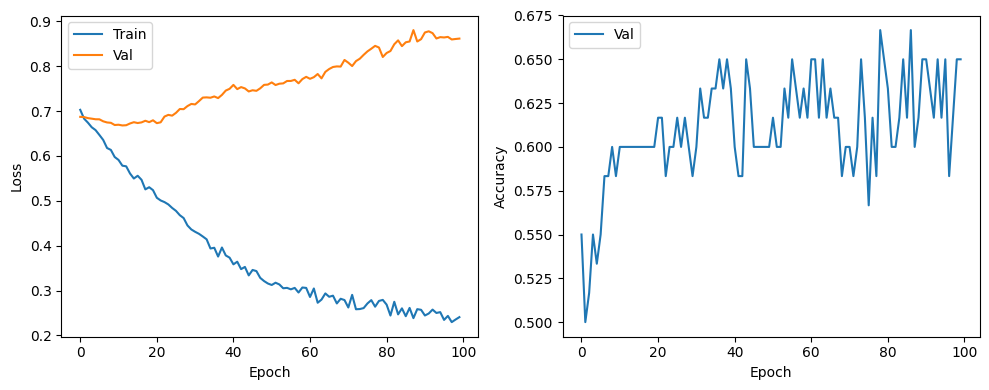

In [11]:
# Plot losses and accuracies
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


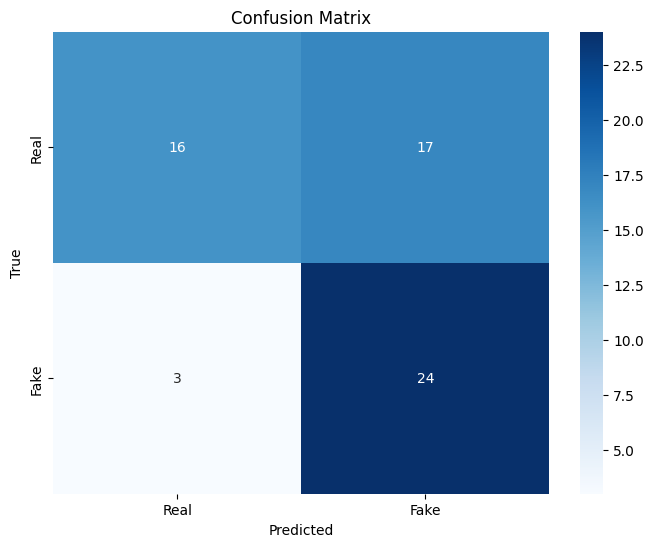

In [12]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names=['Real', 'Fake']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_labels, test_preds)

In [13]:
def print_classification_report(y_true, y_pred, class_names=['Real', 'Fake']):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:")
    print(report)

# Print classification report
print_classification_report(test_labels, test_preds)

Classification Report:
              precision    recall  f1-score   support

        Real       0.84      0.48      0.62        33
        Fake       0.59      0.89      0.71        27

    accuracy                           0.67        60
   macro avg       0.71      0.69      0.66        60
weighted avg       0.73      0.67      0.66        60



In [14]:
model_path = "models/real_fake_video_classifier_vit.pth"
torch.save(video_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to models/real_fake_video_classifier_vit.pth
